In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from xgboost import XGBRegressor

from classes.data_handler import DataHandler, Filter

pd.set_option('display.max_columns', None)

#1 recupération des données

#2 analyse des données

3 nettoyage des données

4 choix du type d'entrainement

5 choix du nmodele

### **1. Récupération des données** 

On extrait les données pertinentes du dataset

In [2]:
def extract_data(cities: list[str], types_local: list[str]) -> None:
    for city in cities:
        for type_local in types_local:
            filters = [
                Filter('Commune', '==', city),
                Filter('Type local', '==', type_local),
                Filter('Nature mutation', '==', 'vente'),
                Filter('Valeur fonciere', 'notnull', None),
                Filter('Surface reelle bati', 'notnull', None),
                #Filter('Nombre pieces principales', '==', 4),
            ]

            df = DataHandler.extract_data("data/ValeursFoncieres-2022.txt", filters)
            if type_local == "maison":
                df = df[["Surface reelle bati", "Nombre pieces principales", "Type local", "Surface terrain", "Nombre de lots", "Valeur fonciere"]]
            else:
                df = df[["Surface reelle bati", "Nombre pieces principales", "Type local", "Nombre de lots", "Valeur fonciere"]]
            df = DataHandler.add_data(df)
            df = DataHandler.clean_data(df)
            DataHandler.persist_data(df, f"data/{city}_{type_local}.csv")

# extract_data(["lille"], ["appartement", "maison"])

### **2. Analyse & nettoyage des données** 

On observe les données pour déterminer les colonnes à exploiter, traiter les aberrations éventuelles, etc..
On affiche d'abord un tableau descriptif de chaque colonne :

In [3]:
df = pd.read_csv("data/lille_maison.csv", sep=',', low_memory=False)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Surface reelle bati,1052.0,90.562738,38.885996,18.000000,67.000000,84.000000,104.000000,415.0
Nombre pieces principales,1052.0,4.288973,1.415610,1.000000,3.000000,4.000000,5.000000,13.0
Surface terrain,1052.0,146.271863,114.957851,16.000000,75.000000,123.000000,179.000000,1004.0
Nombre de lots,1052.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
prix_m2,1052.0,2953.839811,1018.318549,338.709677,2253.177966,2866.964286,3588.060897,5875.0


Observons les valeurs extrêmes

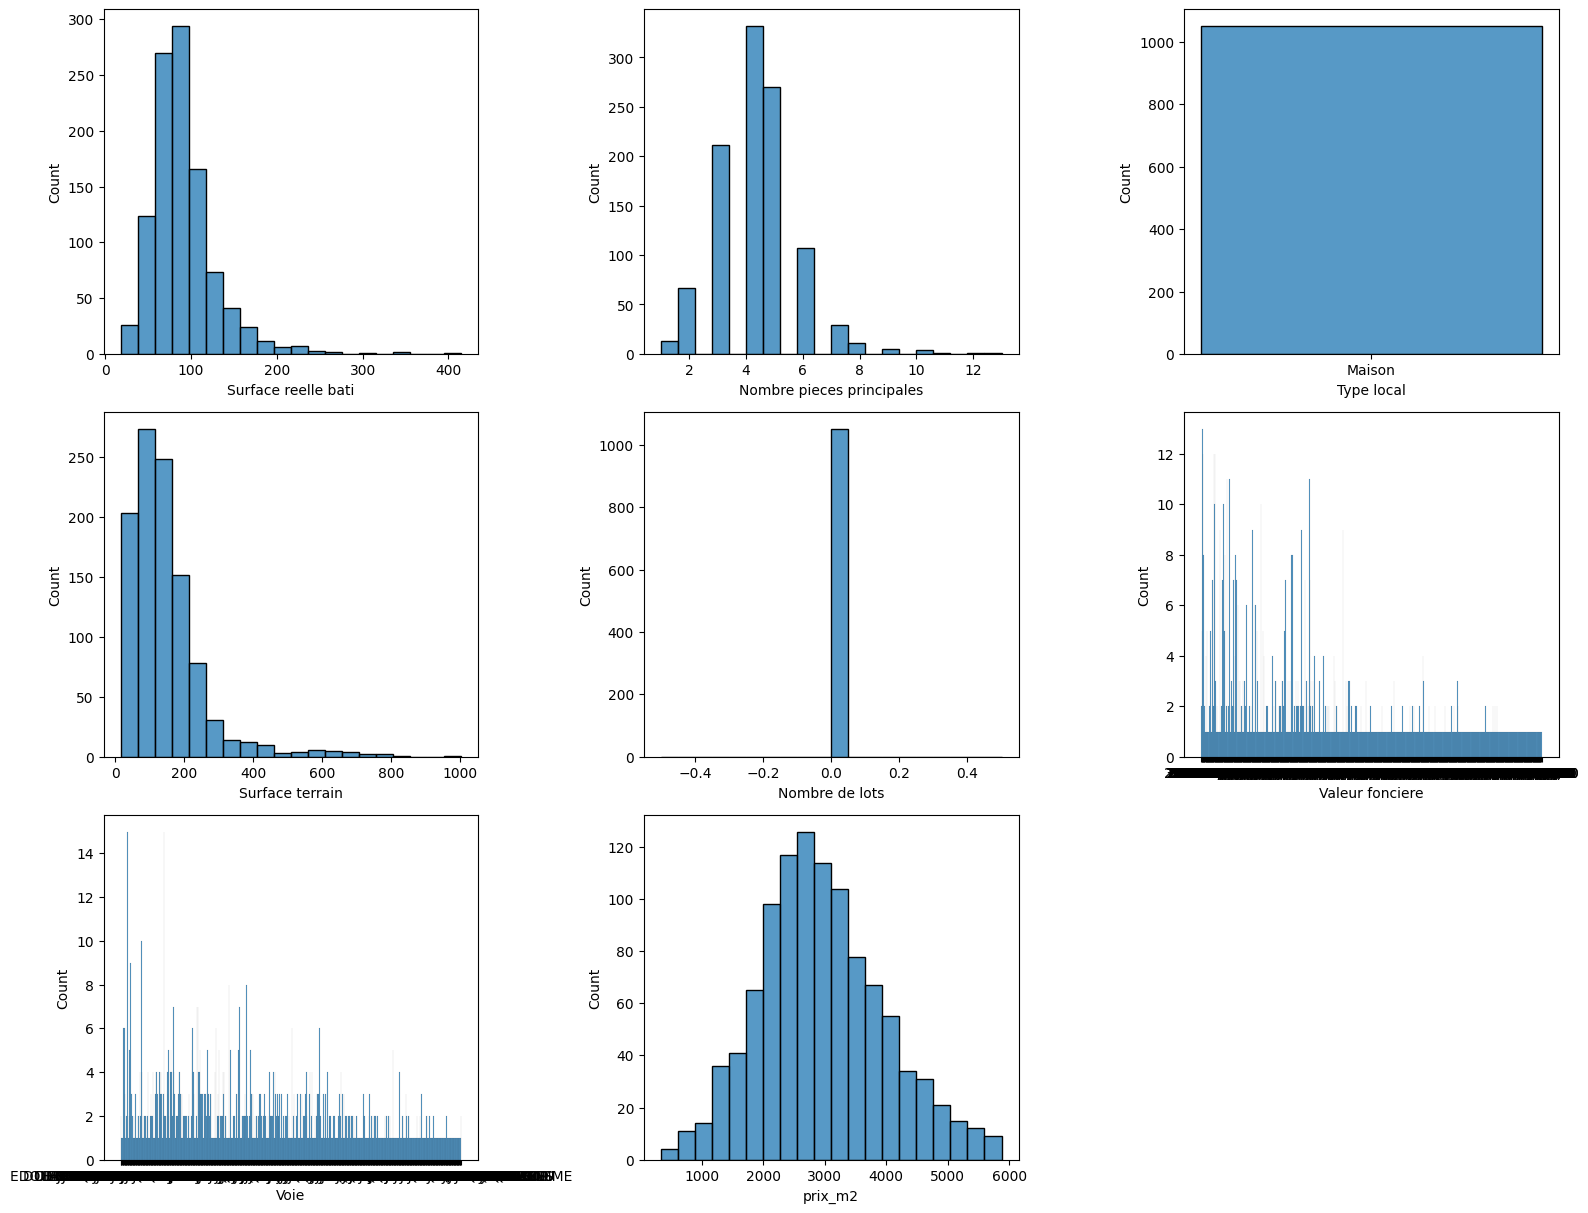

In [4]:
cols = df.columns

plt.figure(figsize=(16,40))
for i, col in enumerate(cols, 1):
    plt.subplot(10, 3, i)
    sns.histplot(df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

On va chercher et supprimer les valeurs aberrantes (outliers)

In [5]:
def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (df[column] < lower_bound) | (df[column] > upper_bound)

outliers = get_outliers(df, 'prix_m2')

df = df[~outliers].copy()

Afficher la matrice de corrélation

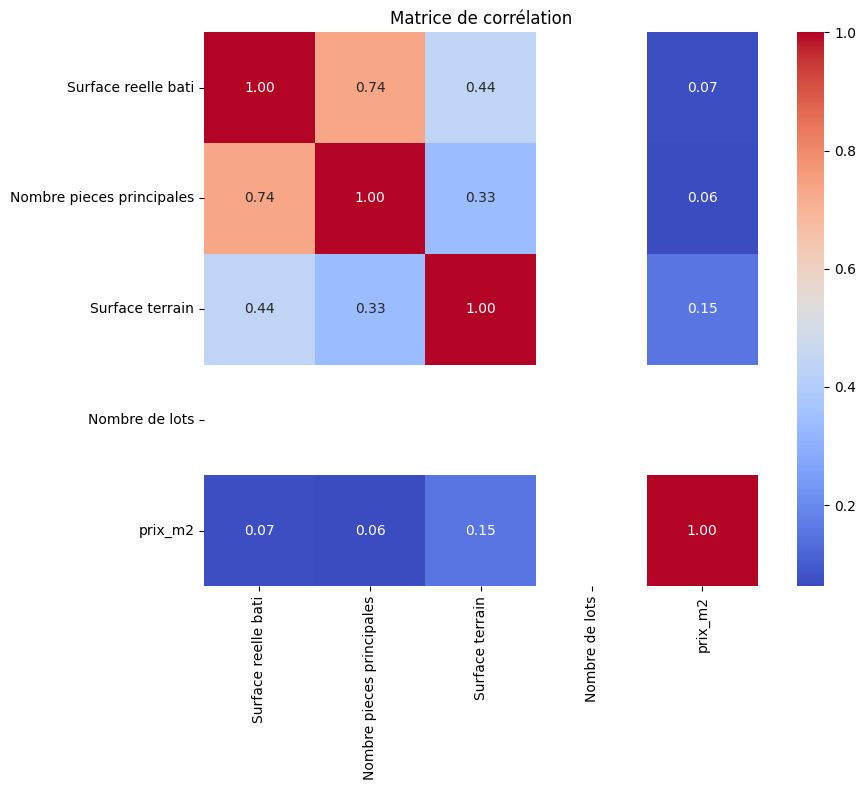

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

### 3. Entraînement

#### 3.a Régression linéaire

On peut désormais préparer les données pour l'entraînement et entraîner le modèle de régression linéaire

In [7]:
evaluation_metrics = {}


X = df[["Surface reelle bati", "Surface terrain", "Nombre pieces principales"]].values
y = df[["prix_m2"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Observons les résultats du modèle

In [8]:
y_train_pred_scaled = model.predict(X_train_scaled)

y_pred_scaled = model.predict(X_test_scaled)
mse_train = mean_squared_error(y_test_scaled, y_pred_scaled)

evaluation_metrics['LinearRegression'] = {
    "MSE": mse_train,
    "RMSE": np.sqrt(mse_train),
    "R²": r2_score(y_test_scaled, y_pred_scaled)
}

print(evaluation_metrics['LinearRegression'])

{'MSE': 1.0324883245003942, 'RMSE': np.float64(1.0161143264910668), 'R²': -0.005239895397902483}


Les résultats sont totalement nuls

#### 3.b Decision Tree Regressor

On peut désormais préparer les données pour l'entraînement et entraîner le modèle DecisionTreeRegressor

In [9]:
X = df[["Surface reelle bati", "Surface terrain", "Nombre pieces principales"]].values
y = df[["prix_m2"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

model = DecisionTreeRegressor()
model.fit(X_train_scaled, y_train_scaled)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


Observons les résultats du modèle DecisionTreeRegressor

In [10]:
y_train_pred_scaled = model.predict(X_train_scaled)

y_pred_scaled = model.predict(X_test_scaled)
mse_train = mean_squared_error(y_test_scaled, y_pred_scaled)

evaluation_metrics['DecisionTreeRegressor'] = {
    "MSE": mse_train,
    "RMSE": np.sqrt(mse_train),
    "R²": r2_score(y_test_scaled, y_pred_scaled)
}

print(evaluation_metrics['DecisionTreeRegressor'])

{'MSE': 1.8189470728179875, 'RMSE': np.float64(1.3486834590881538), 'R²': -0.77094318824249}


Les résultats sont absolument inacceptables

#### 3.c RandomForestRegressor

On peut désormais préparer les données pour l'entraînement et entraîner le modèle RandomForestRegressor

In [11]:
X = df[["Surface reelle bati", "Surface terrain", "Nombre pieces principales"]].values
y = df[["prix_m2"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

model = RandomForestRegressor()
model.fit(X_train_scaled, y_train_scaled)

d:\Formation\Suivi\simplon-ai-developer-training\W11\project\real-estate-prices-api\.venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Observons les résultats du modèle RandomForestRegressor

In [12]:
y_train_pred_scaled = model.predict(X_train_scaled)

y_pred_scaled = model.predict(X_test_scaled)
mse_train = mean_squared_error(y_test_scaled, y_pred_scaled)

evaluation_metrics['RandomForestRegressor'] = {
    "MSE": mse_train,
    "RMSE": np.sqrt(mse_train),
    "R²": r2_score(y_test_scaled, y_pred_scaled)
}

print(evaluation_metrics['RandomForestRegressor'])

{'MSE': 1.0533702088432508, 'RMSE': np.float64(1.0263382526454186), 'R²': -0.025570685329771026}


Les résultats sont nuls

3.d Optimisation avec GridSearchCV

In [13]:
X = df[["Surface reelle bati", "Surface terrain", "Nombre pieces principales"]].values
y = df[["prix_m2"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}

model = DecisionTreeRegressor()

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Métrique d'évaluation
    cv=5,  # Validation croisée à 5 plis
    n_jobs=-1,  # Utilise tous les processeurs disponibles
    verbose=1,  # Affiche la progression
    return_train_score=True
)

print("Début de la recherche d'hyperparamètres...")
grid_search.fit(X_train, y_train)

print("\n=== RÉSULTATS DE LA RECHERCHE ===")
print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score CV: {-grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n=== PERFORMANCE SUR TEST ===")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

default_model = DecisionTreeRegressor(random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)

mse_default = mean_squared_error(y_test, y_pred_default)
r2_default = r2_score(y_test, y_pred_default)

print(f"\n=== COMPARAISON AVEC MODÈLE PAR DÉFAUT ===")
print(f"MSE par défaut: {mse_default:.4f}")
print(f"MSE optimisé: {mse:.4f}")
print(f"Amélioration MSE: {((mse_default - mse) / mse_default * 100):.2f}%")
print(f"R² par défaut: {r2_default:.4f}")
print(f"R² optimisé: {r2:.4f}")

evaluation_metrics['DecisionTreeRegressorWithGridSearch'] = {
    "MSE": mse,
    "RMSE": rmse,
    "R²": r2
}

print(evaluation_metrics['DecisionTreeRegressorWithGridSearch'])

results_df = pd.DataFrame(grid_search.cv_results_)

Début de la recherche d'hyperparamètres...
Fitting 5 folds for each of 1008 candidates, totalling 5040 fits

=== RÉSULTATS DE LA RECHERCHE ===
Meilleurs paramètres: {'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20}
Meilleur score CV: 945685.2548

=== PERFORMANCE SUR TEST ===
MSE: 1052851.2074
RMSE: 1026.0854
MAE: 801.9910
R²: -0.0552

=== COMPARAISON AVEC MODÈLE PAR DÉFAUT ===
MSE par défaut: 1720796.4459
MSE optimisé: 1052851.2074
Amélioration MSE: 38.82%
R² par défaut: -0.7246
R² optimisé: -0.0552
{'MSE': 1052851.2074312598, 'RMSE': np.float64(1026.0853801859082), 'R²': -0.05520412287076848}


In [14]:
X = df[["Surface reelle bati", "Surface terrain", "Nombre pieces principales"]].values
y = df[["prix_m2"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.01,
    max_depth=3,
    random_state=78
)

model.fit(X_train_scaled, y_train_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

evaluation_metrics['XGBRegressor'] = {
    "MSE": mse,
    "RMSE": rmse,
    "R²": r2
}

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(XGBRegressor(objective="reg:squarederror"), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)


print(evaluation_metrics['XGBRegressor'])

RMSE: 980.76
MAE: 2971.20
R²: -8.8476
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
{'MSE': 961897.8825537271, 'RMSE': np.float64(980.7639280447294), 'R²': -8.847635086368157}


In [15]:
print(evaluation_metrics)

{'LinearRegression': {'MSE': 1.0324883245003942, 'RMSE': np.float64(1.0161143264910668), 'R²': -0.005239895397902483}, 'DecisionTreeRegressor': {'MSE': 1.8189470728179875, 'RMSE': np.float64(1.3486834590881538), 'R²': -0.77094318824249}, 'RandomForestRegressor': {'MSE': 1.0533702088432508, 'RMSE': np.float64(1.0263382526454186), 'R²': -0.025570685329771026}, 'DecisionTreeRegressorWithGridSearch': {'MSE': 1052851.2074312598, 'RMSE': np.float64(1026.0853801859082), 'R²': -0.05520412287076848}, 'XGBRegressor': {'MSE': 961897.8825537271, 'RMSE': np.float64(980.7639280447294), 'R²': -8.847635086368157}}


                                Modèle           MSE         RMSE        R²
0                     LinearRegression  1.032488e+00     1.016114 -0.005240
1                DecisionTreeRegressor  1.818947e+00     1.348683 -0.770943
2                RandomForestRegressor  1.053370e+00     1.026338 -0.025571
3  DecisionTreeRegressorWithGridSearch  1.052851e+06  1026.085380 -0.055204
4                         XGBRegressor  9.618979e+05   980.763928 -8.847635


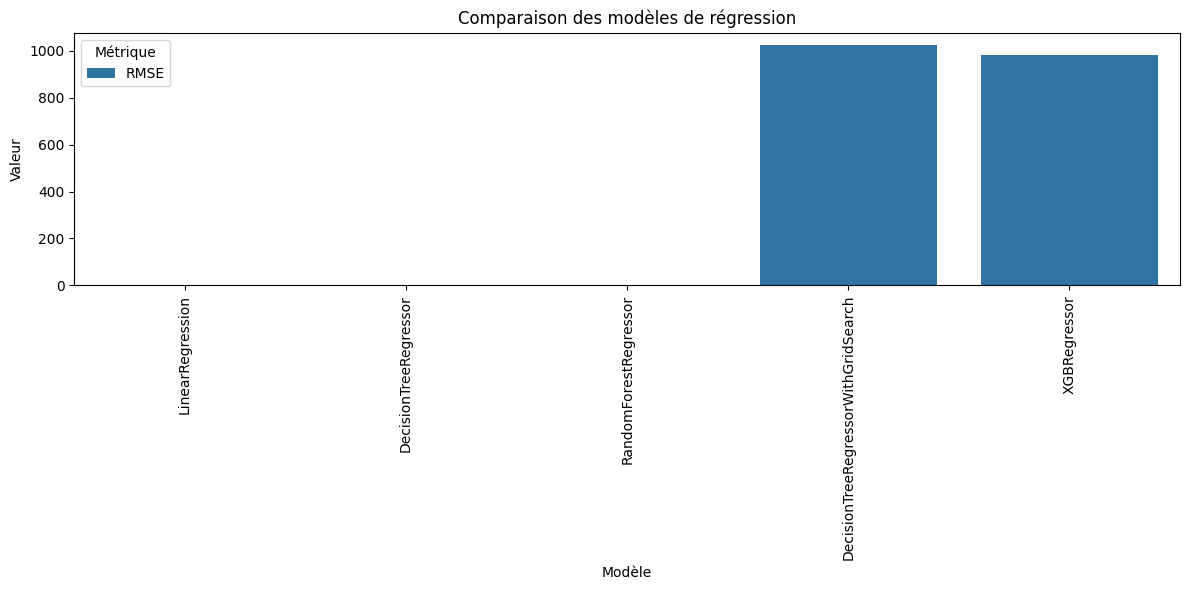

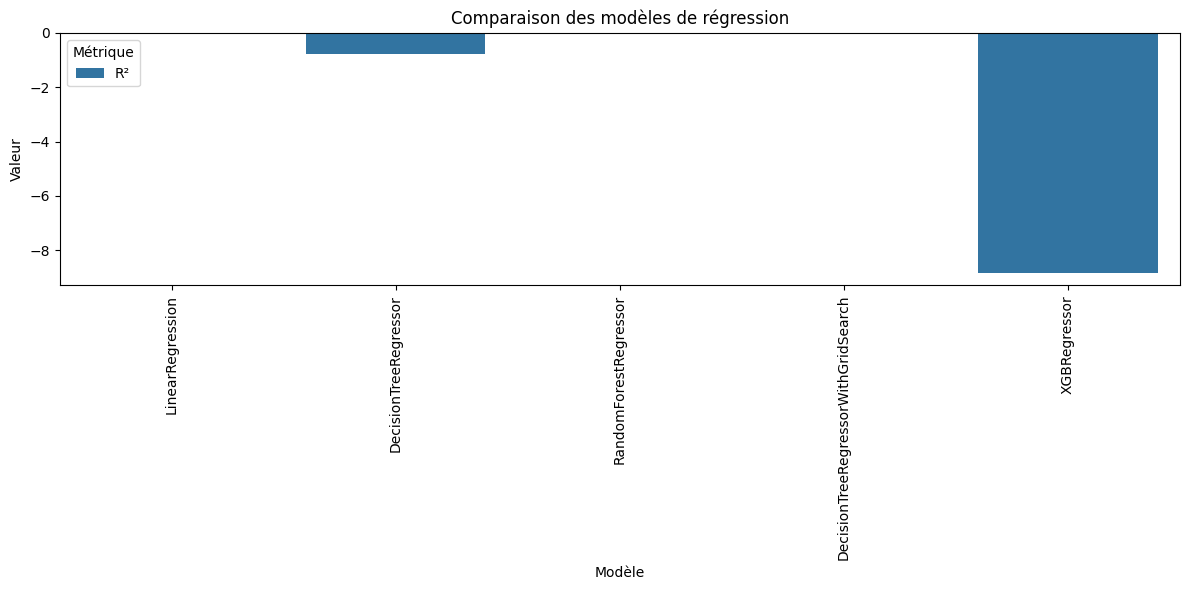

In [16]:
results = pd.DataFrame(evaluation_metrics).T.reset_index().rename(columns={"index": "Modèle"})

print(results)

results_melted = results.melt(id_vars="Modèle", var_name="Métrique", value_name="Valeur")

# Affichage
plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted[results_melted["Métrique"] == "RMSE"], x="Modèle", y="Valeur", hue="Métrique")
plt.title("Comparaison des modèles de régression")
plt.ylabel("Valeur")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Affichage
plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted[results_melted["Métrique"] == "R²"], x="Modèle", y="Valeur", hue="Métrique")
plt.title("Comparaison des modèles de régression")
plt.ylabel("Valeur")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()